# Try HMM

Not entirely sure how these work but will word it out as I go along.


https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

This article is more complicated, but also indepth and explains stuff more. - https://towardsdatascience.com/markov-chains-and-hmms-ceaf2c854788

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [1]:
# imports
from hmmlearn import hmm
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [2]:
# Load in data

# Data Engineering

Initial exploration shown to be promising.
Now do some data engineering to get the targets into the format I want.

In [3]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

df_m_lab

Number of duplicate items in lab data: 9482
Percentage duplicate: 25.309630578688875

Number of duplicate items in turk data: 180378
Percentage duplicate: 21.656231428176945


,target,time,turkId
0,alloc-slider-5,0.000000,ID1
1,alloc-slider-5,0.547000,ID1
3,alloc-slider-5,1.176995,ID1
4,alloc-slider-5,1.790000,ID1
5,html,2.896995,ID1
...,...,...,...
58261,alloc-slider-2,273.796495,ID18
58263,alloc-slider-2,273.836415,ID18
58265,alloc-slider-2,273.924560,ID18
58270,html,274.968440,ID18


In [4]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1)
data_turk.shape

(652537, 1)

In [5]:
# we want to have everything in one long array like this.
# But then we need to create the lengths array thing.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

lab_lengths

[2267,
 2341,
 2341,
 646,
 597,
 3116,
 1531,
 490,
 2666,
 469,
 3754,
 3754,
 2005,
 2005]

In [6]:
# Create Lab data HMM

# Suggestions for number of hidden states.
# https://www.researchgate.net/post/Is_there_any_simple_rule_for_the_number_of_states_in_HMM

# Picked 6 hidden states as thats what the actual system has. sliders 1-5 and other
lab_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(data_lab, lab_lengths) # dont know how many components/hidden states I should have
lab_model

1      -56759.1163             +nan
         2      -47711.6643       +9047.4520
         3      -40440.3305       +7271.3338
         4      -36838.0855       +3602.2450
         5      -33898.1212       +2939.9643
         6      -25847.4826       +8050.6386
         7       -8453.8532      +17393.6294
         8       39070.2581      +47524.1114
         9       56067.9756      +16997.7175
        10       99424.0314      +43356.0558


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [7]:
lab_model.sample(10)

(array([[-0.03686761],
        [ 0.12170202],
        [ 0.005011  ],
        [ 0.08485085],
        [ 0.09094252],
        [ 0.07320014],
        [ 3.00018727],
        [ 3.00004367],
        [ 2.99958977],
        [ 2.99803456]]),
 array([5, 5, 5, 5, 5, 5, 4, 4, 4, 4]))

In [8]:
# Lab Transition Matrix
np.round(lab_model.transmat_, 3)

array([[0.948, 0.004, 0.015, 0.002, 0.02 , 0.012],
       [0.006, 0.948, 0.005, 0.021, 0.005, 0.015],
       [0.027, 0.005, 0.941, 0.003, 0.007, 0.017],
       [0.002, 0.019, 0.001, 0.953, 0.012, 0.014],
       [0.018, 0.005, 0.005, 0.019, 0.942, 0.011],
       [0.013, 0.018, 0.025, 0.015, 0.015, 0.913]])

In [9]:
turk_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(data_turk.reshape(-1, 1), turk_lengths) # dont know how many components/hidden states I should have
turk_model

1    -1362170.3784             +nan
         2    -1168812.4272     +193357.9513
         3     -980231.5847     +188580.8425
         4     -890578.3868      +89653.1978
         5     -820547.0694      +70031.3174
         6     -652062.7092     +168484.3603
         7     -424897.2640     +227165.4452
         8      250420.6334     +675317.8974
         9     1672130.3088    +1421709.6754
        10     3958857.5286    +2286727.2198


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [10]:
# Show transition matrix of hidden states.
# TODO: compute actual system trasitions with n-grams.

np.round(turk_model.transmat_, 2)

array([[0.93, 0.03, 0.  , 0.  , 0.01, 0.02],
       [0.02, 0.93, 0.01, 0.01, 0.02, 0.02],
       [0.  , 0.02, 0.95, 0.  , 0.  , 0.01],
       [0.  , 0.02, 0.  , 0.95, 0.02, 0.  ],
       [0.01, 0.02, 0.  , 0.01, 0.95, 0.  ],
       [0.01, 0.02, 0.02, 0.  , 0.01, 0.94]])

In [11]:
# Create a new data samples of length 10.

np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[15321.819068801915,
 15933.351630939327,
 15935.685087526974,
 4296.340267084628,
 4073.787478617579,
 21229.521961675677,
 10521.516918092302,
 3380.5200035299304,
 18104.63275481958,
 3181.3101293342193,
 25630.308427388693,
 25590.18325876103,
 13596.270240143715,
 13605.720619405176]

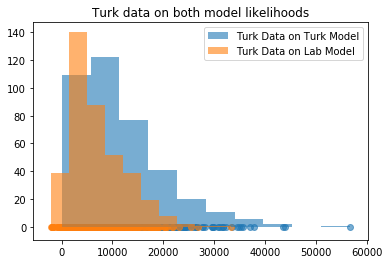

In [13]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

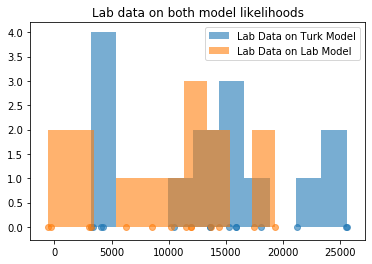

In [14]:
lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

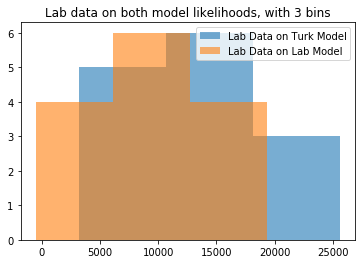

In [15]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

plt.hist(lab_data_turk_model, bins=3, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=3, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods, with 3 bins')
plt.legend(loc='best')
plt.show()

In [16]:
print(lab_model.score(data_lab, lab_lengths))
print(turk_model.score(data_lab, lab_lengths))
print()
print(lab_model.score(data_turk, turk_lengths))
print(turk_model.score(data_turk, turk_lengths))

135568.918028391
191936.57919228665

2877439.5698934393
4491847.116146398


# Reassigning samples

Now run all lab and turk data through both models. 
Assign a predicted label (lab / online) data.
Afterwards compare actual and predicted to see if any samples seem to be missclassified.  

In [17]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def reclassify_samples(turk_model, lab_model, data, lengths):
    # Given a model and some data and lengths return a list of predicted new classes.

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

    return new_classes

reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)    # Try lab data on turk model

User 0: 	 turk: 15321, 	 lab: 11504
User 1: 	 turk: 15933, 	 lab: 11965
User 2: 	 turk: 15935, 	 lab: 11967
User 3: 	 turk: 4296, 	 lab: 3179
User 4: 	 turk: 4073, 	 lab: 3068
User 5: 	 turk: 21229, 	 lab: 14385
User 6: 	 turk: 10521, 	 lab: 6266
User 7: 	 turk: 3380, 	 lab: -315
User 8: 	 turk: 18104, 	 lab: 13686
User 9: 	 turk: 3181, 	 lab: -532
User 10: 	 turk: 25630, 	 lab: 19323
User 11: 	 turk: 25590, 	 lab: 17532
User 12: 	 turk: 13596, 	 lab: 8532
User 13: 	 turk: 13605, 	 lab: 10210


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try lab data on turk model

User 0: 	 turk: 2467, 	 lab: 1868
User 1: 	 turk: 4227, 	 lab: 3180
User 2: 	 turk: 6973, 	 lab: 3661
User 3: 	 turk: 5598, 	 lab: 4177
User 4: 	 turk: 1241, 	 lab: 896
User 5: 	 turk: 1979, 	 lab: -1451
User 6: 	 turk: 2947, 	 lab: 1510
User 7: 	 turk: 5634, 	 lab: 3540
User 8: 	 turk: 17405, 	 lab: 12330
User 9: 	 turk: 6795, 	 lab: 1526
User 10: 	 turk: 4572, 	 lab: 3539
User 11: 	 turk: 14880, 	 lab: 10322
User 12: 	 turk: 2808, 	 lab: 1415
User 13: 	 turk: 6368, 	 lab: 1900
User 14: 	 turk: 5237, 	 lab: 3998
User 15: 	 turk: 12539, 	 lab: 6410
User 16: 	 turk: 2723, 	 lab: -882
User 17: 	 turk: 6061, 	 lab: 1664
User 18: 	 turk: 3788, 	 lab: 2866
User 19: 	 turk: 3248, 	 lab: 2424
User 20: 	 turk: 10500, 	 lab: 7128
User 21: 	 turk: 19460, 	 lab: 13834
User 22: 	 turk: 22594, 	 lab: 12707
User 23: 	 turk: 11376, 	 lab: 6464
User 24: 	 turk: 2978, 	 lab: 2103
User 25: 	 turk: 20133, 	 lab: 13710
User 26: 	 turk: 4124, 	 lab: 2822
User 27: 	 turk: 14179, 	 lab: 8980
User 28: 	 turk:

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


# AMAZING IDEA

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

With some effort could potentially use this to generate new samples for lab data!

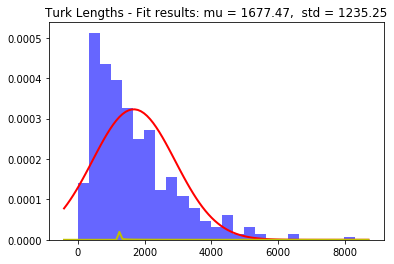

In [19]:
# See if lab_lengths follow a normal distribution
# Lab lengths kind of follow this distribution but not really.
#https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data

from scipy.stats import norm
from scipy.stats import lognorm

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

p2 = lognorm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
plt.plot(x, p2, 'y', linewidth=2)
title = "Turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

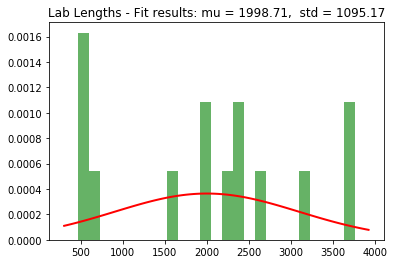

In [20]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Lab Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

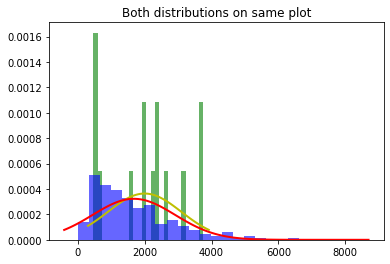

In [21]:
# Both on 1 graph?

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'y', linewidth=2)
plt.title('Both distributions on same plot')

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

plt.show()

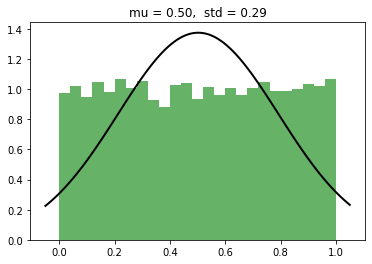

In [22]:
#Showing how a random uniform variable can still look like a gaussian   

x = np.random.rand(10000)

# See if Lab data follows a distrinution

mu, std = norm.fit(x)

plt.hist(x, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

Text(0.5, 1.0, 'Both Lengths - Fit results: mu = 1688.63,  std = 1232.06')

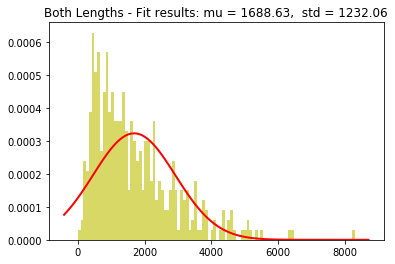

In [23]:
# Combine both data together and see what the distribution looks like
# Probably a bit pointless as the turk data will still be so much more numerous

both_lengths = np.append(turk_lengths,lab_lengths)
both_lengths = np.array(np.append(turk_lengths,lab_lengths), dtype=float)

mu, std = norm.fit(both_lengths)

plt.hist(both_lengths, bins=100, density=True, alpha=0.6, color='y')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Both Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Length Distributions.
Thought this would be a failure at first but this is actually really amazing!
Can CLEARLY see a distribution off turk lengths, and we could explain you not seeing a distribtion in lab data because there is so little many samples.

For Turk and Lab the means are:

|  | Mean | S.D |
| --- | --- | --- |
| Turk | 1677 | 1235 |
| Lab | 1998 | 1095 |

Which are not identical, but as I've showed with the ealier PCA attempts lengths cannot be used to differenciate data points.
Theyre similar enough that I can assume they follow the SAME distribtion.


# Synthesize data
We can generate sequences of any length specified.
todo sample length from a normal distribution matching the lab or turk data depending on what class im creating more samples for.

At the moment this section creates fixed length samples but that will change.

In [24]:
# Sample points from distributions of lengths, using their mean, and sd.

num_generated_samples = 100

# Wanna generate lab sequences as thats the smaller class.
mu, std = norm.fit(lab_lengths)
generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)   # Creating 300 more samples would make the classes even ish.

# https://stackoverflow.com/a/38406535/11902832
# Remove negative values, but now its not really a normal distribution
generated_lengths = abs(generated_lengths).astype(int)



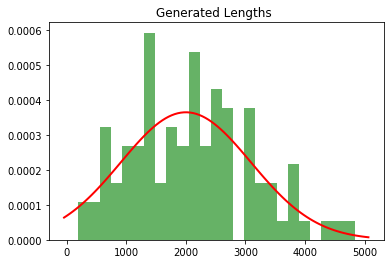

In [25]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(generated_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Generated Lengths "
plt.title(title)

plt.show()

In [26]:
created_data = []
for i in generated_lengths:

    X, Z = lab_model.sample(i)  # This generates a new sample, length of which is taken from the normal distribution

    created_data.append( np.concatenate(X).ravel().astype(int).astype(str).tolist() ) # list of nps flattened, and to ints

len(created_data)

100

In [27]:
# we have array of length 100, each of which contains events of varing lengths.

IDs = []    # This will be the length of the flattened array. will be like ID1, ID1, ID2 etc
targets = []

for i in range(len(created_data)):    
    targets.extend(created_data[i])

    for j in range(len(created_data[i])):
        IDs.append(f'ID{i}')


In [43]:
df = pd.DataFrame({'target':targets, 'turkId':IDs}) 
df.astype(object)
#df['target'] = df['target'].rename({'0' :'html', '1':'Slider-1', '2':'Sliders-2', '3':'Slider-3', '4':'Slider-4', '5':'Slider-5'})

df['target'] = df['target'].replace('0','html')
df['target'] = df['target'].replace('1','alloc-slider-1')
df['target'] = df['target'].replace('2','alloc-slider-2')
df['target'] = df['target'].replace('3','alloc-slider-3')
df['target'] = df['target'].replace('4','alloc-slider-4')
df['target'] = df['target'].replace('5','alloc-slider-5')

df

,target,turkId
0,html,ID0
1,html,ID0
2,html,ID0
3,html,ID0
4,html,ID0
...,...,...
209247,html,ID99
209248,html,ID99
209249,html,ID99
209250,html,ID99


In [44]:
df.to_csv('created_labs.csv')

In [30]:
# Lab Data

from statistics import mean
ave_lab_length = int(np.round(mean(lab_lengths),0) ) # Ave length to nearest whole number
print( ave_lab_length )
print( lab_lengths )

# Now sample points 1999 times to get a created lab data distributions.
# np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

created_data = []

# Create 10 data samples
for i in range(5):
    created_data.append( np.round(lab_model.sample(ave_lab_length)[0],0) )


1999
[2267, 2341, 2341, 646, 597, 3116, 1531, 490, 2666, 469, 3754, 3754, 2005, 2005]


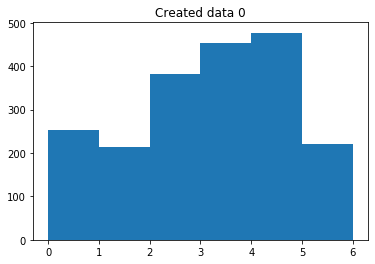

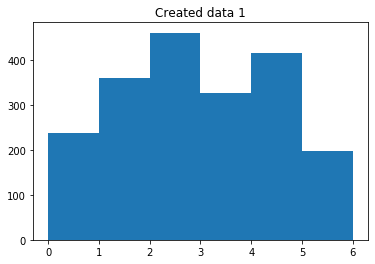

NameError: name 'm_lab' is not defined

In [31]:
plt.hist(created_data[0], bins=[0,1,2,3,4,5,6])
plt.title('Created data 0')
plt.show()
plt.hist(created_data[1], bins=[0,1,2,3,4,5,6])
plt.title('Created data 1')
plt.show()


plt.hist(m_lab, bins=[0,1,2,3,4,5,6])
plt.title('All data')
plt.show()

plt.hist(m_lab[:lab_lengths[0]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 1')
plt.show()
plt.hist(m_lab[lab_lengths[0]+1:lab_lengths[1]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 2')
plt.show()

In [0]:
# Turk created Data
ave_turk_length = int(np.round(mean(turk_lengths),0) ) # Ave length to nearest whole number
print( ave_turk_length )
print( turk_lengths[:10] )

# Now sample points 1999 times to get a created turk data distributions.
# np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

turk_created_data = []

# Create 300 data samples
for i in range(300):
    turk_created_data.append( np.round(turk_model.sample(ave_turk_length)[0],0) )



In [0]:

# Visualize created Data.

plt.hist(turk_created_data[0], bins=[0,1,2,3,4,5,6])
plt.title('Created data 1')
plt.show()
plt.hist(turk_created_data[1], bins=[0,1,2,3,4,5,6])
plt.title('Created data 2')
plt.show()


plt.hist(m_turk, bins=[0,1,2,3,4,5,6])
plt.title('All data')
plt.show()

plt.hist(m_turk[:turk_lengths[0]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 1')
plt.show()
plt.hist(m_turk[turk_lengths[0]+1:turk_lengths[1]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 2')
plt.show()

In [0]:
df_turk_created = pd.DataFrame.from_records( turk_created_data )
#df_turk_created.replace([0.0],'html')
df_turk_created = df_turk_created.replace(0,'html')
df_turk_created = df_turk_created.replace(1,'alloc-slider-1')
df_turk_created = df_turk_created.replace(2,'alloc-slider-2')
df_turk_created = df_turk_created.replace(3,'alloc-slider-3')
df_turk_created = df_turk_created.replace(4,'alloc-slider-4')
df_turk_created = df_turk_created.replace(5,'alloc-slider-5')

In [0]:
created_turk_array = np.array(turk_created_data)
df_turk_created = pd.DataFrame(created_turk_array.flatten())

# Need to create a list of ID's that our generated samples can use.
gen_ids = []
for i in range(300): # 300 new samples created
    gen_ids.append([i]*ave_turk_length)
gen_ids = np.array(gen_ids).flatten()

df_turk_created['turkId'] = gen_ids
df_turk_created.columns = ['target', 'turkId']


df_turk_created['target'] = df_turk_created['target'].replace(0,'html')
df_turk_created['target'] = df_turk_created['target'].replace(1,'alloc-slider-1')
df_turk_created['target'] = df_turk_created['target'].replace(2,'alloc-slider-2')
df_turk_created['target'] = df_turk_created['target'].replace(3,'alloc-slider-3')
df_turk_created['target'] = df_turk_created['target'].replace(4,'alloc-slider-4')
df_turk_created['target'] = df_turk_created['target'].replace(5,'alloc-slider-5')
df_turk_created

In [ ]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1)
data_turk.shape